<a href="https://colab.research.google.com/github/angelica1412/Recomendation-Online-Course/blob/main/Online_Course.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import csv
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from google.colab import drive
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

drive.mount("/content/drive")


base_path = '/content/drive/My Drive/Big Data/'


# Load datasets (skip bad lines & use proper quoting)
alison = pd.read_csv(base_path + 'alison_courses.csv', quoting=csv.QUOTE_MINIMAL, on_bad_lines='skip')
coursera = pd.read_csv(base_path + 'coursera_courses.csv', quoting=csv.QUOTE_MINIMAL, on_bad_lines='skip', sep=';')
udemy = pd.read_csv(base_path + 'udemy_courses.csv', quoting=csv.QUOTE_MINIMAL, on_bad_lines='skip', sep=';')

# Lihat header dari masing-masing file
print("Alison:", alison.columns.tolist())
print("Coursera:", coursera.columns.tolist())
print("Udemy:", udemy.columns.tolist())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Alison: ['category', 'certificate', 'description', 'difficulty', 'duration', 'image_url', 'price', 'scrape_date', 'title', 'url']
Coursera: ['kategori_id', 'kategori_name', 'courses_id', 'courses_bahasa', 'courses_title', 'courses_description', 'courses_level', 'courses_harga', 'courses_url', 'courses_image', 'courses_deskripsi', 'courses_rating', 'courses_reviews', 'courses_durasi', 'courses_tags']
Udemy: ['kategori_id', 'kategori_name', 'courses_id', 'courses_bahasa', 'courses_title', 'courses_description', 'courses_level', 'courses_harga', 'courses_url', 'courses_image', 'courses_deskripsi', 'courses_subscribers', 'courses_rating', 'courses_reviews', 'courses_durasi', 'courses_tags']


In [ ]:
alison_normalized = pd.DataFrame({
    'title': alison['title'],
    'description': alison['description'],
    'price': alison['price'],
    'level': alison['difficulty'],
    'language': 'English',
    'duration': alison['duration'],
    'url': alison['url'],
    'platform': 'alison'
})
print ("\n Alison")
print(alison_normalized.head())
print("Jumlah data Alison :", len(alison_normalized))

coursera_normalized = pd.DataFrame({
    'title': coursera['courses_title'],
    'description': coursera['courses_description'],
    'price': coursera['courses_harga'],
    'level': coursera['courses_level'],
    'language': coursera['courses_bahasa'],
    'duration': coursera['courses_durasi'],
    'url': coursera['courses_url'],
    'platform': 'coursera'
})
print ("\n Coursera")
print(coursera_normalized.head())
print("Jumlah data Coursera :", len(coursera_normalized))

udemy_normalized = pd.DataFrame({
    'title': udemy['courses_title'],
    'description': udemy['courses_deskripsi'],
    'price': udemy['courses_harga'],
    'level': udemy['courses_level'],
    'language': udemy['courses_bahasa'],
    'duration': udemy['courses_durasi'],
    'url': udemy['courses_url'],
    'platform': 'udemy'
})
print ("\n Udemy")
print(udemy_normalized.head())
print("Jumlah data Udemy :", len(udemy_normalized))

# Hitung baris yang punya minimal 1 NaN per dataset
print("Jumlah baris mengandung NaN per dataset:")
print("Alison   :", alison_normalized.isna().any(axis=1).sum())
print("Coursera :", coursera_normalized.isna().any(axis=1).sum())
print("Udemy    :", udemy_normalized.isna().any(axis=1).sum())


 Alison
                                               title  \
0  ISO/IEC 27001 - Dynamics of Information Securi...   
1                           CompTIA A+ 1000 - Part 2   
2  Diploma in ISO 27001:2022 - Information Securi...   
3                          Empower Yourself For Free   
4  ISO 20000 - Principles of IT Service Managemen...   

                                         description price  \
0  This free online course on ISO 27001 explains ...  Free   
1  This free online CompTIA A+ course will teach ...  Free   
2  Master the intricacies of information security...  Free   
3  This free online CompTIA A+ course will teach ...  Free   
4  This free online ISO/IEC 20000 course explains...  Free   

                level language          duration  \
0      BEGINNER LEVEL  English    3-4\nAvg Hours   
1  INTERMEDIATE LEVEL  English   6-10\nAvg Hours   
2  INTERMEDIATE LEVEL  English  10-15\nAvg Hours   
3  INTERMEDIATE LEVEL  English               NaN   
4      BEGINNER LEVEL

In [ ]:
df = pd.concat([alison_normalized, coursera_normalized, udemy_normalized], ignore_index=True)

print(df.head())

                                               title  \
0  ISO/IEC 27001 - Dynamics of Information Securi...   
1                           CompTIA A+ 1000 - Part 2   
2  Diploma in ISO 27001:2022 - Information Securi...   
3                          Empower Yourself For Free   
4  ISO 20000 - Principles of IT Service Managemen...   

                                         description price  \
0  This free online course on ISO 27001 explains ...  Free   
1  This free online CompTIA A+ course will teach ...  Free   
2  Master the intricacies of information security...  Free   
3  This free online CompTIA A+ course will teach ...  Free   
4  This free online ISO/IEC 20000 course explains...  Free   

                level language          duration  \
0      BEGINNER LEVEL  English    3-4\nAvg Hours   
1  INTERMEDIATE LEVEL  English   6-10\nAvg Hours   
2  INTERMEDIATE LEVEL  English  10-15\nAvg Hours   
3  INTERMEDIATE LEVEL  English               NaN   
4      BEGINNER LEVEL  English

In [ ]:
df.replace(['', ' ', 'nan', 'NaN', 'none', 'None', 'NONE'], np.nan, inplace=True)

print("Jumlah total baris sebelum dropna:", len(df))
print("Jumlah baris yang akan dihapus karena ada NaN:", df.isna().any(axis=1).sum())

df.dropna(inplace=True)
print("Jumlah total baris setelah dropna:", len(df))

Jumlah total baris sebelum dropna: 10333
Jumlah baris yang akan dihapus karena ada NaN: 8
Jumlah total baris setelah dropna: 10325


In [ ]:
# Level Category
# Bersihkan tanda baca dari semua kolom teks
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', str(text))

for col in ['title', 'description', 'level', 'language']:
    df[col] = df[col].apply(remove_punctuation)

# Bersihkan teks (lowercase semua kolom string)
text_cols = ['title', 'description', 'level', 'language', 'duration']
for col in text_cols:
    df[col] = df[col].astype(str).str.lower().str.strip()

# Bersihkan kolom level (hapus kata 'level')
df['level'] = df['level'].str.replace('level', '').str.strip()

# Mapping level jadi angka
def level_map(text):
    text = str(text).lower()
    if 'all s' in text:
        return 1
    elif 'beginner' in text:
        return 2
    elif 'intermediate' in text:
        return 3
    elif 'advanced' in text:
        return 4
    elif 'expert' in text:
        return 5
    else:
        return None  # atau bisa return 0 jika ingin tetap menyimpan

df['level'] = df['level'].map(level_map)
df = df[df['level'].notna()]
df['level'] = df['level'].astype(int)

In [ ]:
# Price Category
def convert_to_rupiah(price):
    try:
        price = str(price).lower().strip()
        if 'free' in price or price == '0':
            return 0
        if '$' in price:
            val = int(price.replace('$', '').strip()) * 17000
            return round(val)
        return int(price.replace(',', '').replace('rp', '').strip())
    except:
        return np.nan

df['price_rp'] = df['price'].apply(convert_to_rupiah)

def get_price_category(price):
    if price == 0:
        return 1
    elif price <= 250_000:
        return 2
    elif price <= 500_000:
        return 3
    elif price <= 750_000:
        return 4
    elif price <= 1_000_000:
        return 5
    else:
        return 6

df['price_cat'] = df['price_rp'].apply(get_price_category)
print (df['price_rp'])
print (df['price_cat'])

0             0.0
1             0.0
2             0.0
4             0.0
5             0.0
           ...   
10328    249000.0
10329    249000.0
10330    419000.0
10331    409000.0
10332    249000.0
Name: price_rp, Length: 10325, dtype: float64
0        1
1        1
2        1
4        1
5        1
        ..
10328    2
10329    2
10330    3
10331    3
10332    2
Name: price_cat, Length: 10325, dtype: int64


In [ ]:
# Language Category
def language_category(lang):
    if 'indonesian' in str(lang).lower() or 'id' in str(lang).lower():
        return 1
    elif 'english' in str(lang).lower() or 'en' in str(lang).lower():
        return 2
    return 3

df['language_cat'] = df['language'].apply(language_category)

In [ ]:
# Duration Category
def clean_duration_text(text):
    if not isinstance(text, str):
        return text
    # Hapus kata-kata pengganggu
    text = text.lower()
    text = re.sub(r'\b(avg|average|on average)\b', '', text)
    text = re.sub(r'hours?|hrs?|menit|minutes?', '', text)
    text = re.sub(r'[\(\)]', '', text)
    text = re.sub(r'[\s]+', ' ', text).strip()
    return text

df['duration'] = df['duration'].apply(clean_duration_text)

def extract_hours(duration_str):
    match = re.findall(r'([\d.]+)', duration_str)
    if len(match) == 1:
        return float(match[0])
    elif len(match) == 2:
        return (float(match[0]) + float(match[1])) / 2
    return 0

def duration_category(hours):
    if hours < 1:
        return 1
    elif hours <= 3:
        return 2
    elif hours <= 10:
        return 3
    elif hours <= 25:
        return 4
    else:
        return 5

df['duration_hours'] = df['duration'].apply(extract_hours)
df['duration_cat'] = df['duration_hours'].apply(duration_category)
print(df)

                                                   title  \
0      isoiec 27001  dynamics of information security...   
1                                 comptia a 1000  part 2   
2      diploma in iso 270012022  information security...   
4      iso 20000  principles of it service management...   
5                                 comptia a 1000  part 1   
...                                                  ...   
10328                   cloudnative applications in java   
10329  mastering leetcode with easiest explaination j...   
10330  nextjs react nextauth serverless api fullstack...   
10331  top 50 dynamic programming java algorithms cod...   
10332      ajax  for beginners a very basic introduction   

                                             description   price  level  \
0      this free online course on iso 27001 explains ...    Free      2   
1      this free online comptia a course will teach y...    Free      3   
2      master the intricacies of information security.

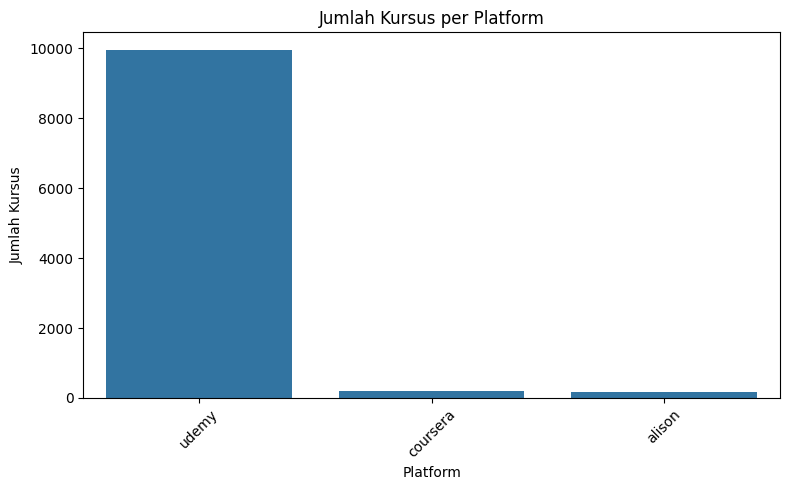

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='platform', order=df['platform'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Jumlah Kursus per Platform')
plt.xlabel('Platform')
plt.ylabel('Jumlah Kursus')
plt.tight_layout()
plt.show()


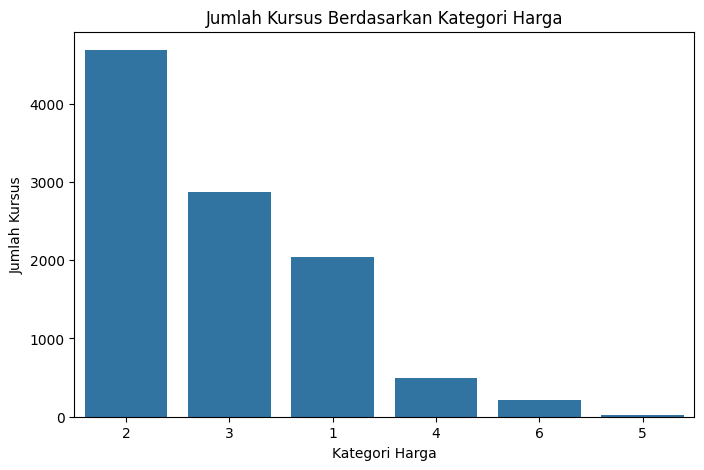

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='price_cat', order=df['price_cat'].value_counts().index)
plt.title('Jumlah Kursus Berdasarkan Kategori Harga')
plt.xlabel('Kategori Harga')
plt.ylabel('Jumlah Kursus')
plt.show()

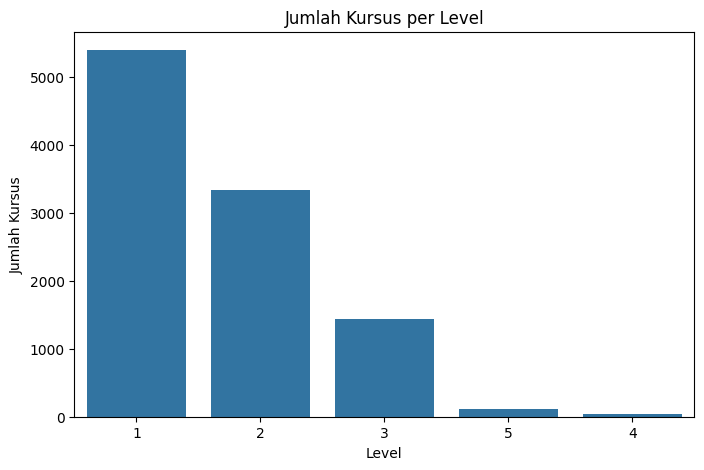

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='level', order=df['level'].value_counts().index)
plt.title('Jumlah Kursus per Level')
plt.xlabel('Level')
plt.ylabel('Jumlah Kursus')
plt.show()

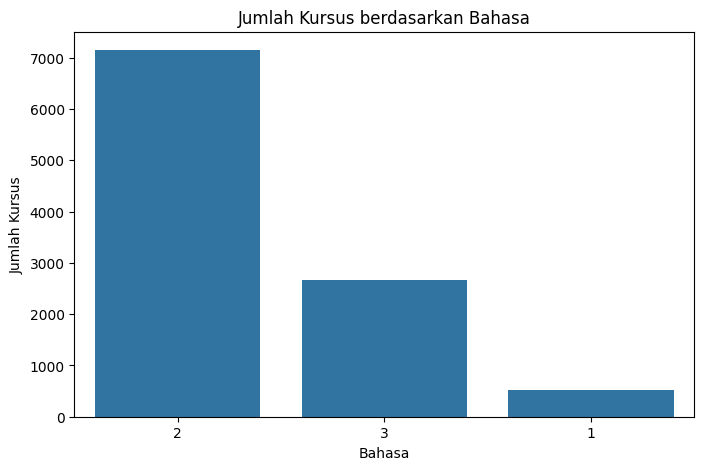

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='language_cat', order=df['language_cat'].value_counts().index)
plt.title('Jumlah Kursus berdasarkan Bahasa')
plt.xlabel('Bahasa')
plt.ylabel('Jumlah Kursus')
plt.show()


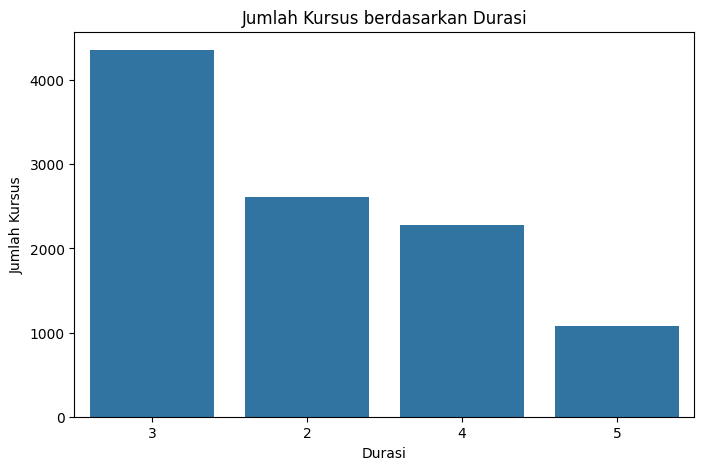

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='duration_cat', order=df['duration_cat'].value_counts().index)
plt.title('Jumlah Kursus berdasarkan Durasi')
plt.xlabel('Durasi')
plt.ylabel('Jumlah Kursus')
plt.show()

In [ ]:
# Map level angka ke teks
level_map_text = {1: 'all', 2: 'beginner', 3: 'intermediate', 4: 'advanced', 5: 'expert'}
df['level_text'] = df['level'].map(level_map_text)

# Map language_cat
language_map_text = {1: 'indonesian', 2: 'english', 3: 'other'}
df['language_text'] = df['language_cat'].map(language_map_text)

# Map price_cat
price_map_text = {
    1: 'free', 2: '1-250.000', 3: '250.001-500.000', 4: '500.001-750.000', 5: '750.001-1.000.000', 6: '>1.000.000',
}
df['price_text'] = df['price_cat'].map(price_map_text)

# Map duration_cat
duration_map_text = {
    1: '0-1 hours', 2: '1-3 hours', 3: '3-10 hours', 4: '10-25 hours', 5: '>25 hours'
}
df['duration_text'] = df['duration_cat'].map(duration_map_text)

# Gabungkan fitur teks untuk keyword matching
df['content_text'] = (
    df['title'] + ' ' +
    df['description']
)

# Gabungkan semua fitur untuk similarity umum
df['all_features_text'] = (
    df['content_text'] + ' ' +
    df['level_text'] + ' ' +
    df['language_text'] + ' ' +
    df['price_text'] + ' ' +
    df['duration_text']
)


# TF-IDF untuk konten (keyword) keyword yang meliputi judul dan deskripsi diprioritaskan
tfidf_content = TfidfVectorizer(
    ngram_range=(1, 2),
    stop_words='english',
    max_features=3000,
    min_df=1
)
X_content = tfidf_content.fit_transform(df['content_text'])

# TF-IDF untuk semua fitur
tfidf_all = TfidfVectorizer(
    ngram_range=(1, 2),
    stop_words='english',
    max_features=2000,
    min_df=1
)
X_all_features = tfidf_all.fit_transform(df['all_features_text'])

print("Content TF-IDF shape:", X_content.shape)
print("All features TF-IDF shape:", X_all_features.shape)

Content TF-IDF shape: (10325, 3000)
All features TF-IDF shape: (10325, 2000)


In [ ]:
def recommend_courses_similarity(df, X_content, X_all_features, tfidf_content, tfidf_all,
                                keyword, target_level=None, target_language=None,
                                target_price_range=None, target_duration=None,
                                top_n=5, keyword_weight=0.6): #keyword weight untuk mengatur seberapa berpengaruh keyword dibanding fitur lainnya

    # 1. Hitung similarity berdasarkan keyword (prioritas tinggi)
    keyword_vector = tfidf_content.transform([keyword])
    content_similarities = cosine_similarity(keyword_vector, X_content).flatten()

    # 2. Buat query untuk fitur lain
    query_features = []

    # Level
    if target_level is not None:
        level_text = level_map_text.get(target_level, '')
        query_features.append(level_text)

    # Language
    if target_language is not None:
        language_text = language_map_text.get(target_language, '')
        query_features.append(language_text)

    # Price
    if target_price_range is not None:
        price_text = price_map_text.get(target_price_range, '')
        query_features.append(price_text)

    # Duration
    if target_duration is not None:
        duration_text = duration_map_text.get(target_duration, '')
        query_features.append(duration_text)

    # Gabungkan query untuk semua fitur
    full_query = keyword + ' ' + ' '.join(query_features)

    # 3. Hitung similarity untuk semua fitur
    all_features_vector = tfidf_all.transform([full_query])
    all_features_similarities = cosine_similarity(all_features_vector, X_all_features).flatten()

    # 4. Gabungkan similarity dengan bobot
    # Keyword mendapat prioritas lebih tinggi
    final_similarities = (keyword_weight * content_similarities +
                         (1 - keyword_weight) * all_features_similarities)

    # 7. Ambil top N
    top_indices = final_similarities.argsort()[::-1][:top_n]

    # 8. Buat hasil rekomendasi
    result = df.iloc[top_indices].copy()
    result = result[['title', 'platform', 'price_rp', 'level_text', 'language_text',
                    'price_text', 'duration_text', 'url']].reset_index(drop=True)

    # Tambahkan skor similarity
    result['content_similarity'] = content_similarities[top_indices]
    result['features_similarity'] = all_features_similarities[top_indices]

    return result

In [ ]:
def evaluate_recommendation_advanced(result_df, keyword, target_features=None):
    if result_df.empty:
        return "Tidak ada rekomendasi untuk dievaluasi."

    keyword = keyword.lower()

    # Evaluasi relevansi keyword
    keyword_relevan = 0
    for idx, row in result_df.iterrows():
        title_lower = str(row['title']).lower()
        if keyword in title_lower:
            keyword_relevan += 1

    keyword_precision = keyword_relevan / len(result_df) if len(result_df) > 0 else 0

    # Evaluasi kecocokan fitur target
    feature_matches = 0
    if target_features:
        for idx, row in result_df.iterrows():
            matches = 0
            total_features = 0

            if 'level' in target_features:
                total_features += 1
                if target_features['level'] in str(row['level_text']).lower():
                    matches += 1

            if 'language' in target_features:
                total_features += 1
                if target_features['language'] in str(row['language_text']).lower():
                    matches += 1

            if total_features > 0:
                feature_matches += matches / total_features

        feature_precision = feature_matches / len(result_df) if len(result_df) > 0 else 0
    else:
        feature_precision = 0

    return {
        'keyword_precision': keyword_precision,
        'feature_precision': feature_precision,
        'keyword_relevan_count': keyword_relevan,
        'total_recommended': len(result_df),
        'avg_content_similarity': result_df['content_similarity'].mean(),
    }

In [ ]:
print("\n=== SISTEM REKOMENDASI BERBASIS SIMILARITY ===")

result1 = recommend_courses_similarity(
    df=df,
    X_content=X_content,
    X_all_features=X_all_features,
    tfidf_content=tfidf_content,
    tfidf_all=tfidf_all,
    keyword='Python',
    target_level=2,  # beginner
    target_language=2,  # english
    target_price_range=2,  # 1-250.000
    target_duration=2,  # 1-3 hours
    top_n=5,
    keyword_weight=0.60  # 60% untuk keyword, 40% untuk fitur lain
)

print(result1[['title', 'platform', 'level_text', 'language_text', 'price_text',
              'duration_text', 'content_similarity', 'features_similarity', 'url']].to_string())

# Evaluasi
eval_result1 = evaluate_recommendation_advanced(
    result1,
    'Python',
    target_features={'level': 'beginner', 'language': 'english'}
)
print(f"\nEvaluasi:")
print(f"Keyword Precision: {eval_result1['keyword_precision']:.2f}")
print(f"Feature Precision: {eval_result1['feature_precision']:.2f}")
print(f"Avg Content Similarity: {eval_result1['avg_content_similarity']:.3f}")


=== SISTEM REKOMENDASI BERBASIS SIMILARITY ===
                                                        title platform level_text language_text       price_text duration_text  content_similarity  features_similarity                                                                                      url
0                     python for astronomers and astrophysics    udemy   beginner         other        1-250.000     1-3 hours            1.000000             0.505626                                      https://www.udemy.com/course/python-for-astronomer/
1                                    core python for everyone    udemy   beginner       english  250.001-500.000    3-10 hours            0.580440             0.611904                                   https://www.udemy.com/course/core-python-for-everyone/
2                                       python for biologists    udemy   beginner         other        1-250.000    3-10 hours            0.527009             0.666636              

In [ ]:
print("\n=== Testing 1 ===")

result1 = recommend_courses_similarity(
    df=df,
    X_content=X_content,
    X_all_features=X_all_features,
    tfidf_content=tfidf_content,
    tfidf_all=tfidf_all,
    keyword='React',
    target_level=2,  # beginner
    target_language=2,  # english
    target_price_range=1,  # free
    target_duration=2,  # 1-3 hours
    top_n=5,
    keyword_weight=0.60  # 60% untuk keyword, 40% untuk fitur lain
)

print(result1[['title', 'platform', 'level_text', 'language_text', 'price_text',
              'duration_text', 'content_similarity', 'features_similarity', 'url']].to_string())

# Evaluasi
eval_result1 = evaluate_recommendation_advanced(
    result1,
    'React',
    target_features={'level': 'beginner', 'language': 'english'}
)
print(f"\nEvaluasi:")
print(f"Keyword Precision: {eval_result1['keyword_precision']:.2f}")
print(f"Feature Precision: {eval_result1['feature_precision']:.2f}")
print(f"Avg Content Similarity: {eval_result1['avg_content_similarity']:.3f}")


=== Testing 1 ===
                                                        title platform    level_text language_text       price_text duration_text  content_similarity  features_similarity                                                                                      url
0                                           react three fiber    udemy      beginner         other  250.001-500.000    3-10 hours            0.761652             0.395327                                          https://www.udemy.com/course/react-three-fiber/
1  react responsive portfolio website  complete react project    udemy           all       english        1-250.000    3-10 hours            0.693070             0.412298  https://www.udemy.com/course/react-responsive-portfolio-website-complete-react-project/
2  handson react build advanced react js frontend with expert    udemy  intermediate       english  250.001-500.000   10-25 hours            0.649347             0.376384                               

In [ ]:
print("\n=== Testing 2 ===")

result1 = recommend_courses_similarity(
    df=df,
    X_content=X_content,
    X_all_features=X_all_features,
    tfidf_content=tfidf_content,
    tfidf_all=tfidf_all,
    keyword='Finance',
    target_level=2,  # beginner
    target_language=2,  # english
    target_price_range=1,  # free
    target_duration=3,  # 3-10 hours
    top_n=5,
    keyword_weight=0.60  # 60% untuk keyword, 40% untuk fitur lain
)

print(result1[['title', 'platform', 'level_text', 'language_text', 'price_text',
              'duration_text', 'content_similarity', 'features_similarity', 'url']].to_string())

# Evaluasi
eval_result1 = evaluate_recommendation_advanced(
    result1,
    'Finance',
    target_features={'level': 'beginner', 'language': 'english'}
)
print(f"\nEvaluasi:")
print(f"Keyword Precision: {eval_result1['keyword_precision']:.2f}")
print(f"Feature Precision: {eval_result1['feature_precision']:.2f}")
print(f"Avg Content Similarity: {eval_result1['avg_content_similarity']:.3f}")


=== Testing 2 ===
                                                      title  platform    level_text language_text       price_text duration_text  content_similarity  features_similarity                                                              url
0                                handson python for finance     udemy  intermediate       english             free    3-10 hours            0.685441             0.668341        https://www.udemy.com/course/hands-on-python-for-finance/
1          decentralized finance defi the future of finance  coursera  intermediate    indonesian       >1.000.000     1-3 hours            0.711281             0.532015  https://coursera.org/specializations/decentralized-finance-duke
2  mb500 dynamics 365 finance and operations apps developer     udemy           all       english  250.001-500.000    3-10 hours            0.555809             0.472373                  https://www.udemy.com/course/mb-500-d365fnodev/
3        foundational finance for strateg

In [ ]:
print("\n=== Testing 3 ===")

result1 = recommend_courses_similarity(
    df=df,
    X_content=X_content,
    X_all_features=X_all_features,
    tfidf_content=tfidf_content,
    tfidf_all=tfidf_all,
    keyword='Git',
    target_level=3,  # intermediate
    target_language=3,  # indonesian
    target_price_range=1,  # free
    target_duration=1,  # 0-1 hours
    top_n=5,
    keyword_weight=0.60  # 60% untuk keyword, 40% untuk fitur lain
)

print(result1[['title', 'platform', 'level_text', 'language_text', 'price_text',
              'duration_text', 'content_similarity', 'features_similarity', 'url']].to_string())

# Evaluasi
eval_result1 = evaluate_recommendation_advanced(
    result1,
    'Git',
    target_features={'level': 'intermediate', 'language': 'indonesian'}
)
print(f"\nEvaluasi:")
print(f"Keyword Precision: {eval_result1['keyword_precision']:.2f}")
print(f"Feature Precision: {eval_result1['feature_precision']:.2f}")
print(f"Avg Content Similarity: {eval_result1['avg_content_similarity']:.3f}")


=== Testing 3 ===
                                                   title platform    level_text language_text       price_text duration_text  content_similarity  features_similarity                                                                    url
0                                 overcoming fear of git    udemy  intermediate       english        1-250.000     1-3 hours            0.776813             0.449983                   https://www.udemy.com/course/overcoming-fear-of-git/
1        git for geeks quick git training for developers    udemy  intermediate       english        1-250.000    3-10 hours            0.747934             0.444065                            https://www.udemy.com/course/git-for-geeks/
2            git essentials for beginners 3 courses in 1    udemy      beginner       english        1-250.000    3-10 hours            0.754417             0.392863  https://www.udemy.com/course/mastering-git-for-beginners-and-experts/
3    git complete the definitive 

In [ ]:
print("\n=== Testing 4 ===")

result1 = recommend_courses_similarity(
    df=df,
    X_content=X_content,
    X_all_features=X_all_features,
    tfidf_content=tfidf_content,
    tfidf_all=tfidf_all,
    keyword='JavaScript',
    target_level=3,  # intermediate
    target_language=2,  # english
    target_price_range=2,  # 1-250.000
    target_duration=2,  # 1-3 hours
    top_n=5,
    keyword_weight=0.60  # 60% untuk keyword, 40% untuk fitur lain
)

print(result1[['title', 'platform', 'level_text', 'language_text', 'price_text',
              'duration_text', 'content_similarity', 'features_similarity', 'url']].to_string())

# Evaluasi
eval_result1 = evaluate_recommendation_advanced(
    result1,
    'JavaScript',
    target_features={'level': 'intermediate', 'language': 'english'}
)
print(f"\nEvaluasi:")
print(f"Keyword Precision: {eval_result1['keyword_precision']:.2f}")
print(f"Feature Precision: {eval_result1['feature_precision']:.2f}")
print(f"Avg Content Similarity: {eval_result1['avg_content_similarity']:.3f}")


=== Testing 4 ===
                                                  title platform    level_text language_text price_text duration_text  content_similarity  features_similarity                                                                                  url
0  javascript intermediate level 2  all about functions    udemy  intermediate       english  1-250.000     1-3 hours            0.394095             0.750907            https://www.udemy.com/course/javascript-intermediate-mastering-functions/
1         javascript for coders learn oop in javascript    udemy  intermediate       english  1-250.000   10-25 hours            0.521272             0.545530  https://www.udemy.com/course/advance-javascript-for-coders-learn-oop-in-javascript/
2                     javascript for absolute beginners    udemy      beginner       english  1-250.000     1-3 hours            0.667289             0.313941                      https://www.udemy.com/course/javascript-for-absolute-beginners/
3    

In [ ]:
print("\n=== Testing 5 ===")

result1 = recommend_courses_similarity(
    df=df,
    X_content=X_content,
    X_all_features=X_all_features,
    tfidf_content=tfidf_content,
    tfidf_all=tfidf_all,
    keyword='Laravel',
    target_level=2,  # beginner
    target_language=2,  # english
    target_price_range=3,  # 1-250.000
    target_duration=2,  #1-3 hours
    top_n=5,
    keyword_weight=0.60  # 60% untuk keyword, 40% untuk fitur lain
)

print(result1[['title', 'platform', 'level_text', 'language_text', 'price_text',
              'duration_text', 'content_similarity', 'features_similarity', 'url']].to_string())

# Evaluasi
eval_result1 = evaluate_recommendation_advanced(
    result1,
    'Laravel',
    target_features={'level': 'beginner', 'language': 'english'}
)
print(f"\nEvaluasi:")
print(f"Keyword Precision: {eval_result1['keyword_precision']:.2f}")
print(f"Feature Precision: {eval_result1['feature_precision']:.2f}")
print(f"Avg Content Similarity: {eval_result1['avg_content_similarity']:.3f}")


=== Testing 5 ===
                                                         title platform level_text language_text       price_text duration_text  content_similarity  features_similarity                                                                                                 url
0   master laravel  create highlevel applications with laravel    udemy        all       english  250.001-500.000   10-25 hours            0.867446             0.648643  https://www.udemy.com/course/php-with-laravel-create-advanced-applications-while-learning-laravel/
1                 laravel 12 tutorial for beginners to advance    udemy   beginner       english  250.001-500.000    3-10 hours            0.678994             0.568248                          https://www.udemy.com/course/laravel-10-tutorial-for-beginners-to-advance/
2              professional blogcms development with laravel 5    udemy        all         other  250.001-500.000   10-25 hours            0.698951             0.537732      